<h1 align="center"> Credit Fraud Detector </h1>

<h3> About this Project </h3>
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<h3> Outline </h3>




### 1. Read Processed Data

In [2]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#### 1-1. Import Data

In [3]:
# read processed data  
import pickle
file_path = 'processed_data.pkl'  # Replace with your file path
with open(file_path, 'rb') as file:
    df = pickle.load(file)
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v22,v23,v24,v25,v26,v27,v28,class,amount_sc,time_sc
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


#### 1-2. Train and Test Data

In [6]:
# train-test split original data 

from sklearn.model_selection import train_test_split

X = df.drop('class', axis = 1)
y = df['class']

skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest =  original_ytest.values

# check if similarly distributed
print('-' * 100)
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### 2. Random Undersampling

#### 2-1. Perform Random Undersampling

**Undersampling** is a technique used to address class imbalance in a classification problem. 
- Reduce the number of instances in the majority class to balance the class distribution
- Improve the model's ability to learn from the minority class

In [7]:
# amount of fraud classes 492 rows
fraud_df = df.loc[df['class'] == 1]
non_fraud_df = df.loc[df['class'] == 0][:492]
equal_df = pd.concat([fraud_df, non_fraud_df])

# shuffle rows
uns_df = equal_df.sample(frac = 1, random_state= 34)
uns_df.shape

(984, 31)

Text(0.5, 1.0, 'Equally Distributed Classes')

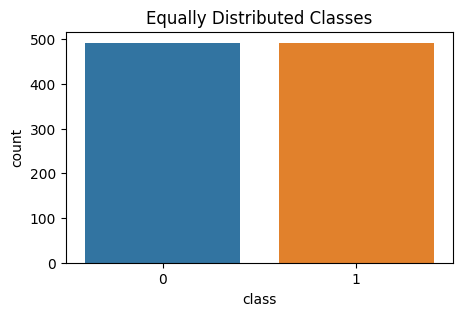

In [8]:
plt.figure(figsize= (5,3))

sns.countplot(x = uns_df['class'])
plt.title('Equally Distributed Classes', fontsize = 12)

#### 2-2. Dimension Reduction

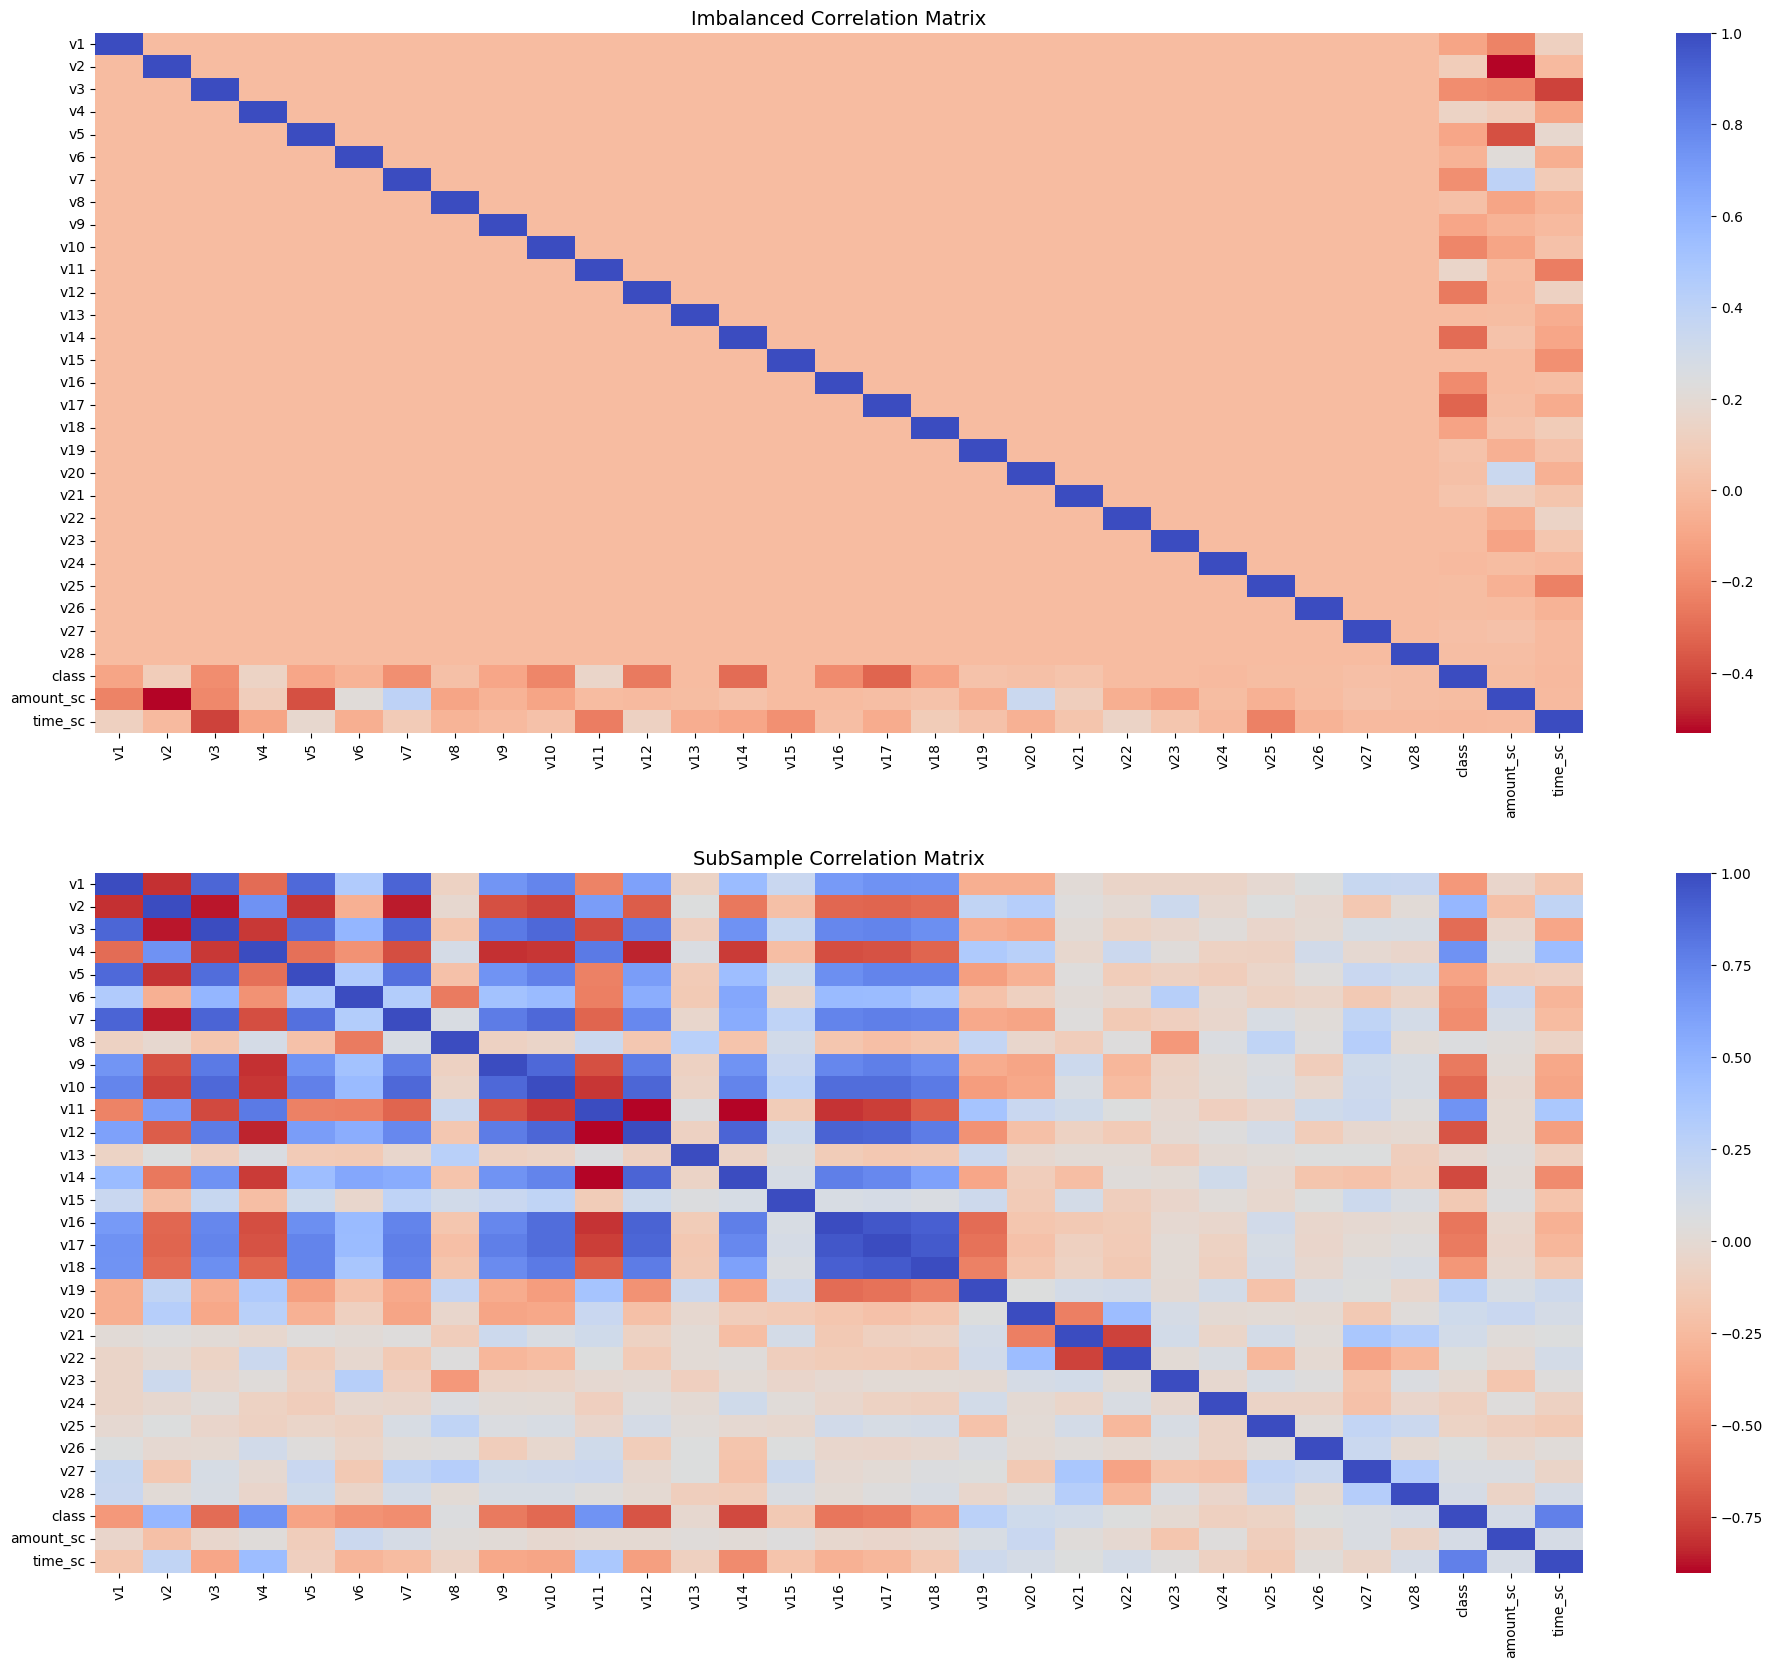

In [9]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = uns_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

In [10]:
v4_fraud_dist = uns_df['v4'].loc[uns_df['class'] == 1].values
v4_fraud_dist

array([ 3.59316052,  5.15352462,  2.51298558,  7.65239936,  6.18596884,
        1.28624391,  0.40866999,  5.34024167,  3.831112  ,  6.20331419,
        2.43418142,  7.74055545,  8.59434189,  0.84775289,  1.18945163,
        5.27089101,  3.40195537,  1.40116573,  6.07826551, 11.92751187,
        0.60576068,  7.04337355,  8.90415677,  6.21476728,  3.32033688,
        2.57204626,  2.35709625,  6.08132108,  2.37836729,  2.40003149,
        4.63241098, 10.46386628,  7.81867331,  8.80736918,  3.55245371,
        7.5460328 ,  4.68000806,  3.58461483, 11.12277143,  0.11677198,
        3.79494904,  0.38260892,  3.12367231,  0.18320845,  3.19364785,
        4.73279513,  6.31066097,  6.03734513,  4.28434596,  3.64394527,
        6.95098294,  5.36402677,  6.89095208,  9.24945924,  5.17781926,
        5.33704803,  7.03111477,  8.25233431,  2.20188352,  3.85970067,
        5.14826255, 10.64850545,  3.78754816,  2.0125543 ,  6.3945737 ,
        2.17990251,  2.99211739,  1.71466918,  8.42583168,  6.67

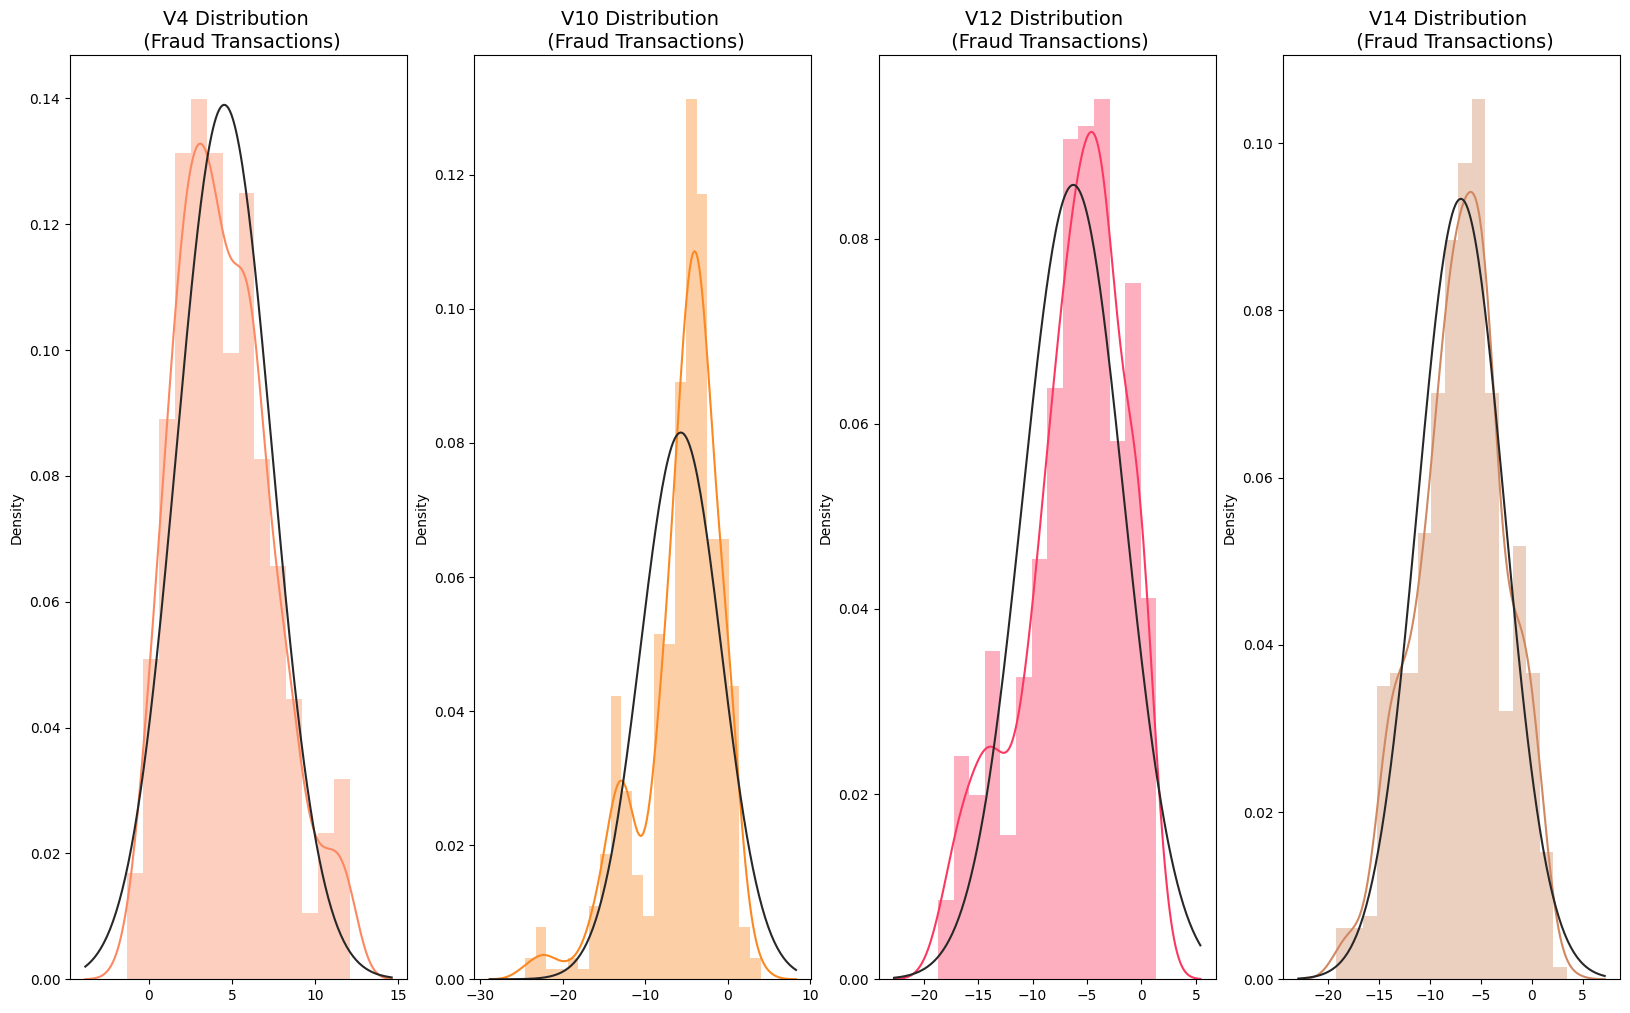

In [11]:
# distribution of v4, v10, v12, v14, highly correlated with class
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 12))

v4_fraud_dist = uns_df['v4'].loc[uns_df['class'] == 1].values
sns.distplot(v4_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = uns_df['v10'].loc[uns_df['class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax2, fit=norm, color='#FB8821')
ax2.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = uns_df['v12'].loc[uns_df['class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax3, fit=norm, color='#FB3861')
ax3.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = uns_df['v14'].loc[uns_df['class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax4, fit=norm, color='#CF8861')
ax4.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

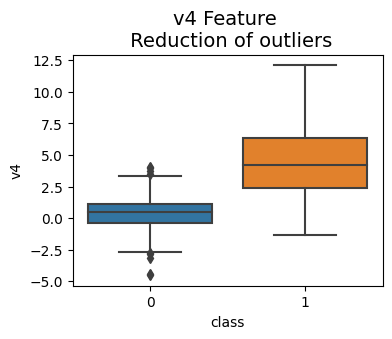

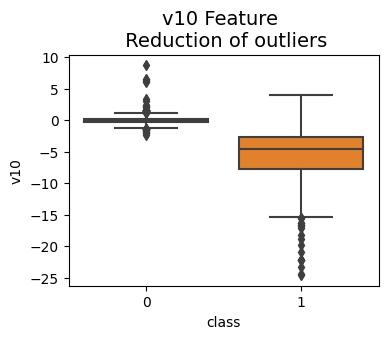

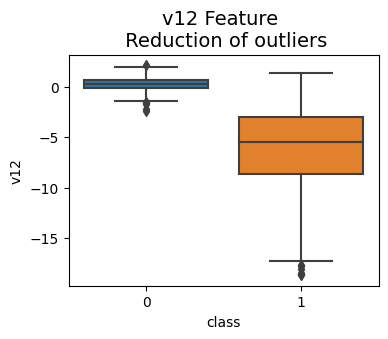

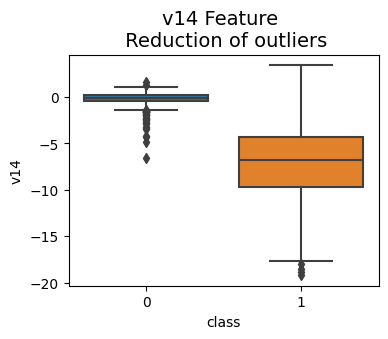

In [13]:
def draw_boxplot_with_outliers(var_list):
    
    for var in var_list:
        plt.figure(figsize=(4, 3))  
        ax = plt.gca()

        sns.boxplot(x="class", y = var, data=uns_df, ax=ax)
        ax.set_title("{} Feature \n Reduction of outliers".format(var), fontsize=14)
        plt.show()

draw_boxplot_with_outliers(['v4', 'v10', 'v12', 'v14'])

In [14]:
# Get rid of outliers
v4_fraud = uns_df['v4'].loc[uns_df['class'] == 1]
q1, q3 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q3 - q1
v4_cutoff = (q3 -q1)*1.5
v4_upper, v4_lower = q3 + v4_cutoff, q1 - v4_cutoff
uns_df = uns_df[(uns_df['v4'] <= v4_upper) & (uns_df['v4'] >= v4_lower)]

v10_fraud = uns_df['v10'].loc[uns_df['class'] == 1]
q1, q3 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q3 - q1
v10_cutoff = (q3 -q1)*1.5
v10_upper, v10_lower = q3 + v10_cutoff, q1 - v10_cutoff
uns_df = uns_df[(uns_df['v10'] <= v10_upper) & (uns_df['v4'] >= v10_lower)]

v12_fraud = uns_df['v12'].loc[uns_df['class'] == 1]
q1, q3 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q3 - q1
v12_cutoff = (q3 -q1)*1.5
v12_upper, v12_lower = q3 + v12_cutoff, q1 - v12_cutoff
uns_df = uns_df[(uns_df['v12'] <= v12_upper) & (uns_df['v12'] >= v12_lower)]

v14_fraud = uns_df['v14'].loc[uns_df['class'] == 1]
q1, q3 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q3 - q1
v14_cutoff = (q3 -q1)*1.5
v14_upper, v14_lower = q3 + v14_cutoff, q1 - v14_cutoff
uns_df = uns_df[(uns_df['v14'] <= v14_upper) & (uns_df['v4'] >= v14_lower)]

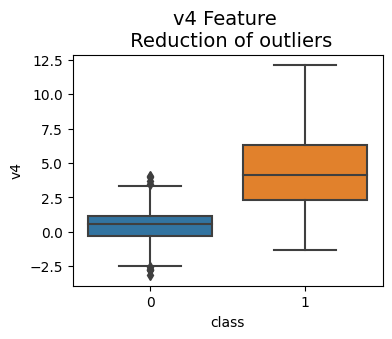

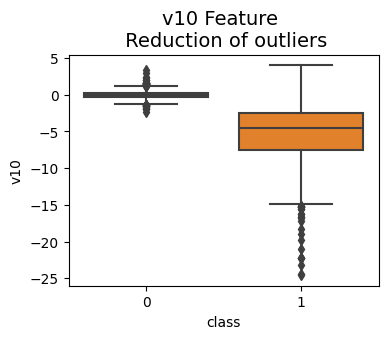

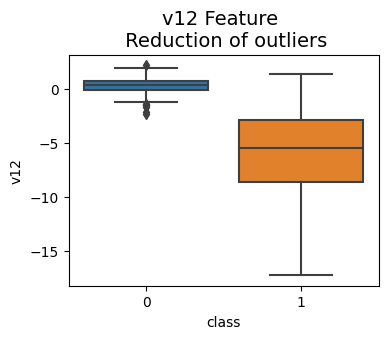

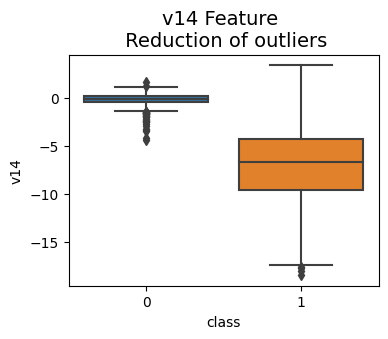

In [16]:
def draw_boxplot_without_outliers(var_list):
    
    for var in var_list:
        plt.figure(figsize=(4, 3))  
        ax = plt.gca()

        sns.boxplot(x="class", y = var, data=uns_df, ax=ax)
        ax.set_title("{} Feature \n Reduction of outliers".format(var), fontsize=14)
        plt.show()

draw_boxplot_without_outliers(['v4', 'v10', 'v12', 'v14'])

#### 2-3. Classifiers

<ul>
<li> <b> Logistic Regression: </b></li>
<li> <b> Support Vector Machines: </b>  </li>
<li> <b> Random Forest Classifier: </b>  </li>
</ul>

In [17]:
# Hyperparameter grid for logistic regression
log_param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2']
}
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

rf_param_grid = {
    'randomforestclassifier__max_depth': [None, 10, 20, 30]  # Example values for max_depth
}

# Group of Classifiers & Param Grids
classifiers = { 
    "LogisticRegression": [LogisticRegression(), log_param_grid],
    "KNearest": [KNeighborsClassifier(), knn_param_grid],
    "RandomForestClassifier": [RandomForestClassifier(), rf_param_grid]
}

In [18]:
# Undersampling while Cross Validation & Finding Best Parameters

def hyper_tune_undersample(model, param_grid):

    undersample_X = df.drop('class', axis=1)
    undersample_y = df['class']

    # pipeline that undersamples and fits classifier
    undersample_train_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), model)
    sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    grid_search = GridSearchCV(estimator=undersample_train_pipeline, param_grid = param_grid,
                           scoring='recall', cv=sss, verbose=1)
                           
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []

    # Implementing undersampling after cross-validation split
    for train, test in sss.split(undersample_X, undersample_y):
        grid_search.fit(undersample_X.iloc[train], undersample_y.iloc[train])
        undersample_prediction = grid_search.predict(undersample_X.iloc[test])

        # get model score
        accuracy.append(grid_search.score(undersample_X.iloc[test], undersample_y.iloc[test]))
        precision.append(precision_score(undersample_y.iloc[test], undersample_prediction))
        recall.append(recall_score(undersample_y.iloc[test], undersample_prediction))
        f1.append(f1_score(undersample_y.iloc[test], undersample_prediction))
        roc_auc.append(roc_auc_score(undersample_y.iloc[test], undersample_prediction))

    print('----------- {} ------------'.format(model.__class__.__name__))
    print('Best parameters:', grid_search.best_params_)
    print('Best recall score:', grid_search.best_score_)
    print('accuracy:', np.mean(accuracy))
    print('precision score:', np.mean(precision))
    print('recall score:', np.mean(recall))
    print('f1 score:', np.mean(f1))
    print('roc_auc_score:', np.mean(roc_auc))

In [19]:
hyper_tune_undersample(classifiers['LogisticRegression'][0], classifiers['LogisticRegression'][1])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------- LogisticRegression ------------
Best parameters: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Best recall score: 0.9618305744888023
accuracy: 0.9106163677592249
precision score: 0.0035962599673073593
recall score: 0.9106163677592249
f1 score: 0.0071618117897951
roc_auc_score: 0.7239855311880554


In [31]:
hyper_tune_undersample(classifiers['KNearest'][0], classifiers['KNearest'][1])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------- KNeighborsClassifier ------------
Best parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Best recall score: 0.9339500162284973
accuracy: 0.9308183879612452
precision score: 0.004545341227708442
recall score: 0.9308183879612452
f1 score: 0.009039922830292538
roc_auc_score: 0.7673084958113385


In [29]:
hyper_tune_undersample(classifiers['RandomForestClassifier'][0], classifiers['RandomForestClassifier'][1])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------- RandomForestClassifier ------------
Best parameters: {'randomforestclassifier__max_depth': 10}
Best recall score: 0.979649464459591
accuracy: 0.9837559266130695
precision score: 0.0018938114844728935
recall score: 0.9837559266130695
f1 score: 0.0037802795973784567
roc_auc_score: 0.5401149539683008


#### 2-4. Final Model with undersampled data

**Precision vs Recall Tradeoff:**
- If more transactions are classified as FRAUD it will lead to higher RECALL, as TP increase and FN decrease (In other words, out of the actual fraud transactions, more will be classified as Fraud)
- On the other hand, PRECISION will decrease. As TP will increase but FP will increase at the same time

In [23]:
from sklearn.metrics import confusion_matrix

log_reg_sm = LogisticRegression(C=100, penalty='l2')
knears_neighbors = KNeighborsClassifier(n_neighbors=3, p=2, weights='uniform')
rf_clf = RandomForestClassifier(max_depth = 10)

log_reg_sm.fit(original_Xtrain, original_ytrain)
y_pred_log_reg = log_reg_sm.predict(original_Xtest)

knears_neighbors.fit(original_Xtrain, original_ytrain)
y_pred_knear = knears_neighbors.predict(original_Xtest)

rf_clf.fit(original_Xtrain, original_ytrain)
y_pred_rf = rf_clf.predict(original_Xtest)

In [24]:
log_reg_cf = confusion_matrix(original_ytest, y_pred_log_reg)
kneighbors_cf = confusion_matrix(original_ytest, y_pred_knear)
rf_cf = confusion_matrix(original_ytest, y_pred_rf)

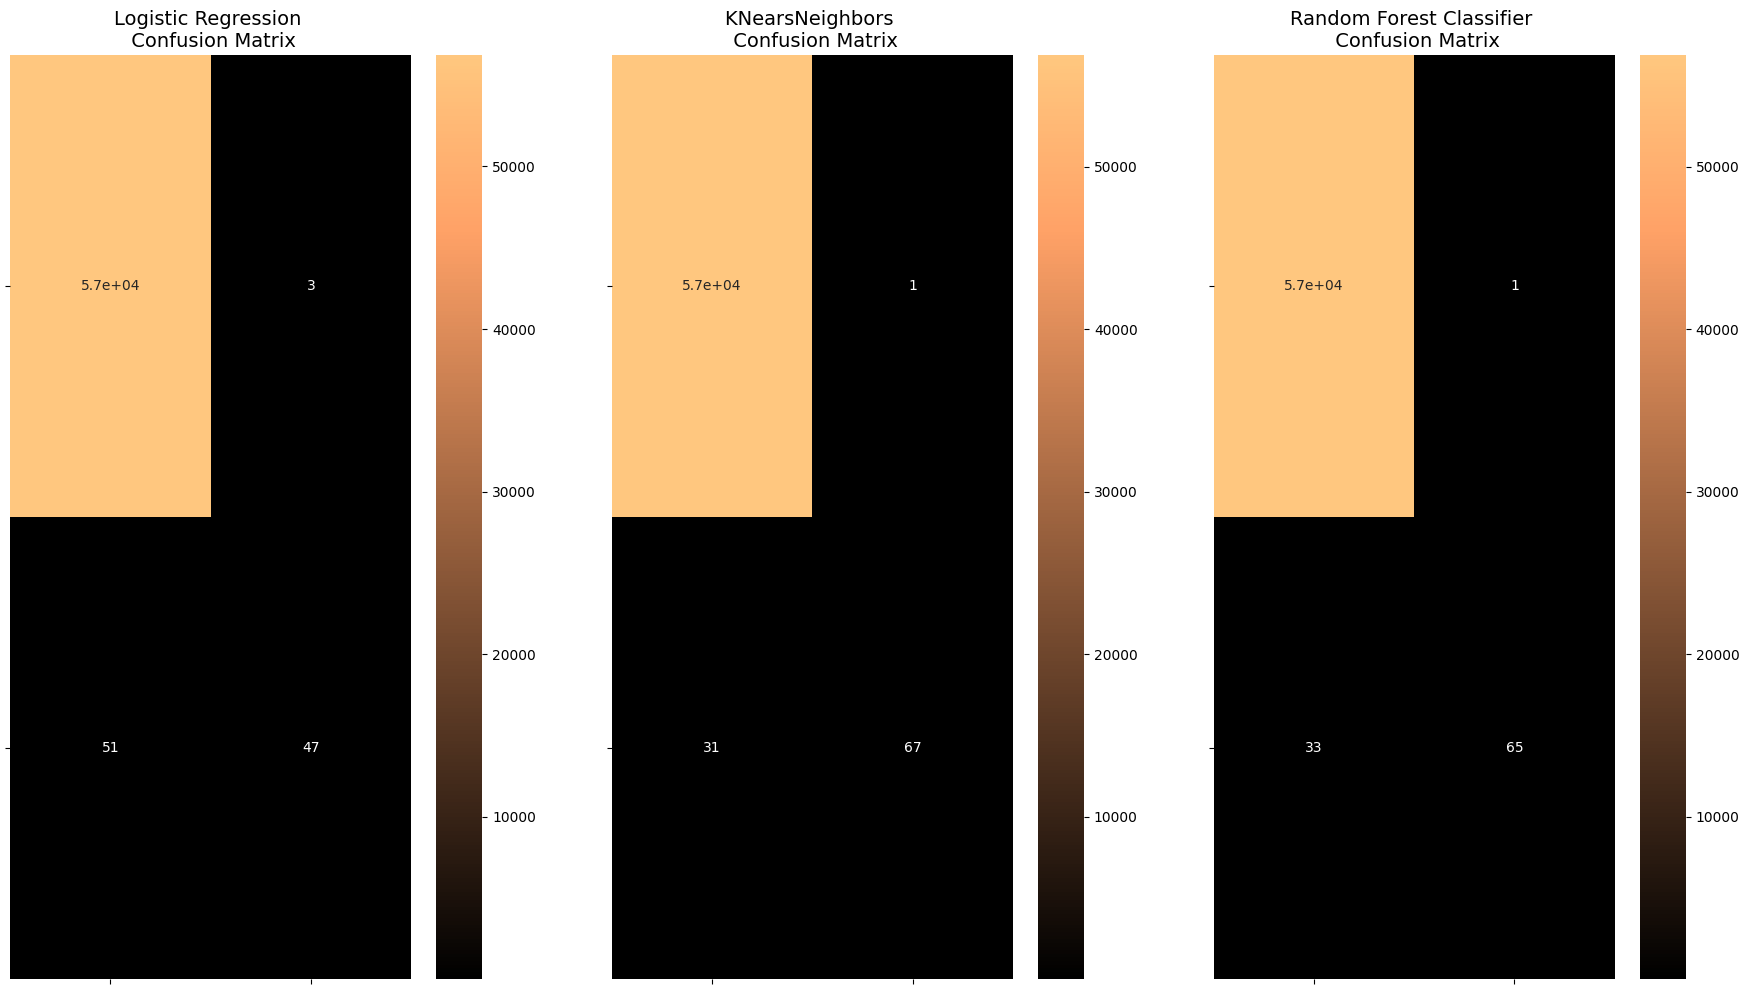

In [27]:
# Confusion Matrix of the Classifiers

fig, ax = plt.subplots(1, 3, figsize=(22, 12))

sns.heatmap(log_reg_cf, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[1], annot=True, cmap=plt.cm.copper)
ax[1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rf_cf, ax=ax[2], annot=True, cmap=plt.cm.copper)
ax[2].set_title("Random Forest Classifier \n Confusion Matrix", fontsize=14)
ax[2].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [28]:
# Final Score

print('Logistic Regression:')
print(classification_report(original_ytest, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(original_ytest, y_pred_knear))

print('Random Forest Classifier:')
print(classification_report(original_ytest, y_pred_rf))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.48      0.64        98

    accuracy                           1.00     56961
   macro avg       0.97      0.74      0.82     56961
weighted avg       1.00      1.00      1.00     56961

KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.66      0.79        98

    accuracy                           1.00     56961
   macro avg       0.99      0.83      0.90     56961
weighted 

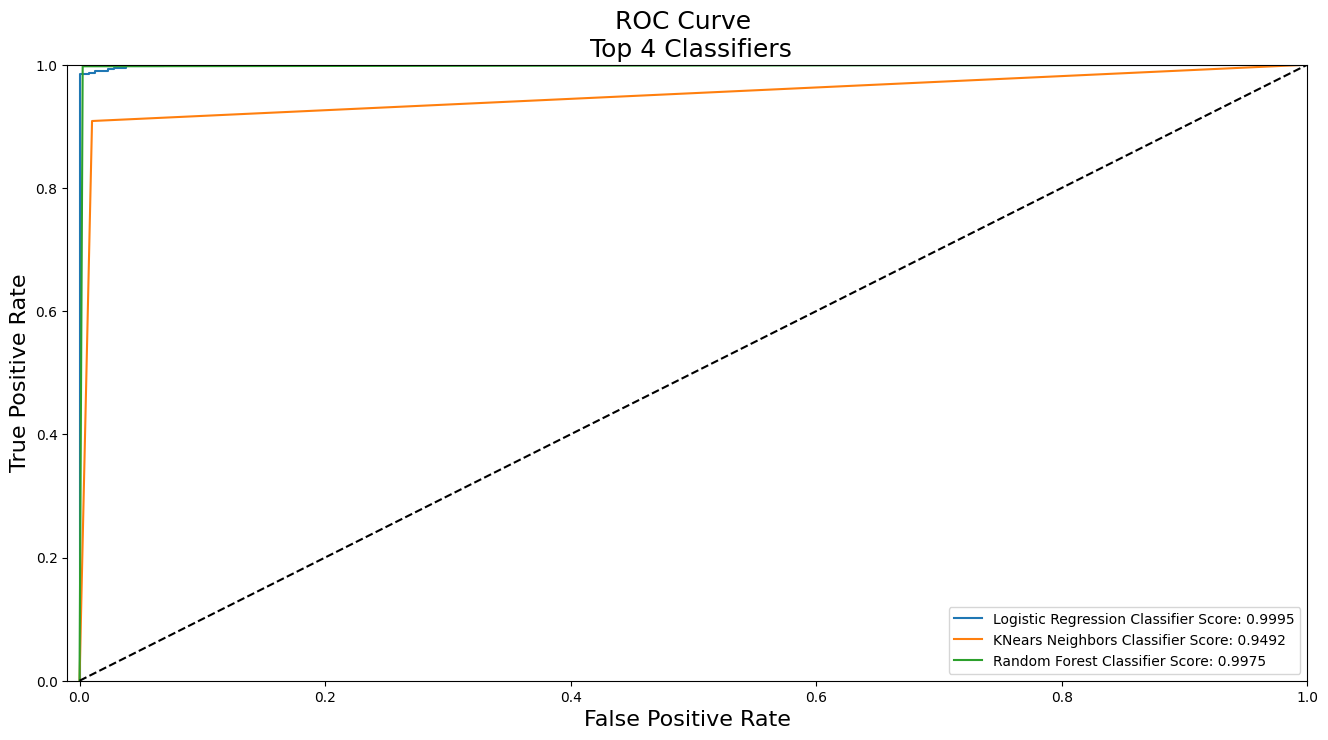

In [45]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, rf_fpr, rf_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, rf_fpr, rf_tpr)
plt.show()

### 3. Random Oversampling with SMOTE

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# find the best parameters 
log_reg_sm = LogisticRegression()
log_reg_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter = 4)

# implement SMOTE Technique
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('accuracy: {}'.format(np.mean(accuracy_lst)))
print('precision: {}'.format(np.mean(precision_lst)))
print('recall: {}'.format(np.mean(recall_lst)))
print('f1: {}'.format(np.mean(f1_lst)))
print('roc_auc: {}'.format(np.mean(auc_lst)))

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9406711401678066
precision: 0.06102858415931541
recall: 0.9137617656604998
f1: 0.11256283418234025
roc_auc: 0.9272397348989937
---------------------------------------------------------------------------------------------------------------------------------------


In [37]:
smote_prediction = best_est.predict(original_Xtest)
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



### 4. Final Tests and Comparison

In [42]:
# Compare Undersampling and SMOTE methods using original dataset

from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
log_reg = LogisticRegression(C=100, penalty='l2')
log_reg.fit(original_Xtrain, original_ytrain)
y_pred = log_reg.predict(original_Xtest)
undersample_score = accuracy_score(original_ytest, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

print('undersample score:', undersample_score, 'oversample score:', oversample_score)

undersample score: 0.9990519829356929 oversample score: 0.9882726777970893
